
### Imports

Let's start by importing the modules we'll need below. The main one is the ```PolyBin``` package, as well as ```Healpy``` for visualization / mask loading.

In [1]:
%pylab inline
import polybin as pb
import healpy
from scipy.interpolate import InterpolatedUnivariateSpline

Populating the interactive namespace from numpy and matplotlib


# 1. Set-Up

# Need more discussion of what signal + mask are!

### Options

Below, we'll set all the user-defined options we will need. These include the map resolution, the number of simulations used, the binning, and the input mask.

In [2]:
# HEALPix settings
Nside = 128
lmax = 3*Nside-1

# Bin edges (can be non-linearly spaced)
l_bins = np.arange(2,100,4)
print("binned lmax: %d"%(np.max(l_bins)))

# Number of random iterations to create Fisher matrix
N_it = 10 # N ~ 100 is sufficient in practice, we'll use 10 for testing

# Number of simulations to use for testing
N_sim = 250

# Whether to include bins only partially satisfying triangle conditions
include_partial_triangles = False

# whether to add a separable reduced bispectrum to the input maps
include_synthetic_b = False
b_input_fac = lambda l1: np.exp(-(l1-2)/40.)*2e-6

# Galactic Mask
# Using GAL040 mask with 2-degree apodization for testing
root = '/projects/QUIJOTE/Oliver/planck/'
maskfile = 'HFI_Mask_GalPlane-apo2_2048_R2.00.fits'

binned lmax: 98


### Fiducial Power and Noise Spectrum

Below, we define a fiducial power and noise spectrum that we'll use to generate the testing simulations, and to weight the data.

In [3]:
from classy import Class
cosmo = Class()

# Define ell arrays
l = np.arange(lmax+1)

# Run CLASS
cosmo.set({'output':'tCl,lCl,mPk','l_max_scalars':lmax+1,'lensing':'yes',
           'omega_b':0.022383,
           'non linear':'no',
           'omega_cdm':0.12011,
           'h':0.6732,
           'm_ncdm':0.06,
           'N_ncdm':1,
           'tau_reio':0.0543,
           'A_s':1e-10*np.exp(3.0448),
           'n_s':0.96605});
cosmo.compute()

# Compute signal C_ell
Cl_dict = cosmo.lensed_cl(lmax);
Cl_th = Cl_dict['tt']*cosmo.T_cmb()**2

# Compute noise C_ell
DeltaT = 60./60.*np.pi/180.*1e-6 # in K-radians
thetaFWHM = 5./60.*np.pi/180. # in radians
Nl_th = DeltaT**2*np.exp(l*(l+1)*thetaFWHM**2/(8.*np.log(2)))*(l>2)

### Load mask

For testing, we use a *Planck* 40\% sky mask with 2-degree apodization applied.

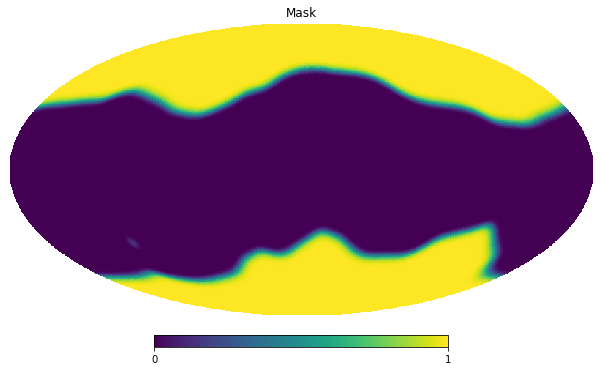

In [4]:
mask = healpy.ud_grade(healpy.read_map(root+maskfile,field=1),Nside)
healpy.mollview(mask,title='Mask')

### Initialize PolyBin class

Let's start by calling the main PolyBin class. This contains a bunch of useful methods, including spherical harmonic transforms (via HEALPix) and code to generate random simulations. We can optionally add an experimental beam here too (note that the input data is *not* expected to be beam-deconvolved, but the output spectra are).

In [133]:
# Load class with fiducial Cl and Nside
beam = 1.+0.*l
base = pb.PolyBin(Nside, beam**2*Cl_th+Nl_th+Cl_th[2]*(l<2),beam)

Next, we'll create some synthetic data with a known $C_\ell$. We can optionally add a bispectrum term: for simplicity, we use a factorized form with $b_{\ell_1\ell_2\ell_3}=\beta_{\ell_1}\beta_{\ell_2}\beta_{\ell_3}$ where $\beta$ was defined above. We will window this data with the *Planck* map.

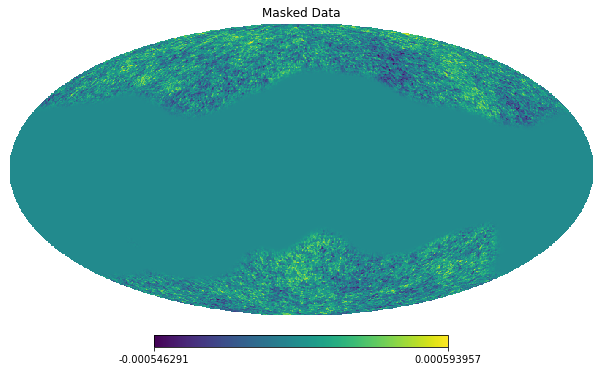

In [134]:
# Generate unmasked data with known C_l and factorized b
# Cl is set to the fiducial spectrum unless otherwise specified
# No beam is included
raw_data = base.generate_data(seed=42, add_B=include_synthetic_b, b_input=b_input_fac)

# Mask the map
data = raw_data*mask

# Plot the data
healpy.mollview(data,title='Masked Data')

### Define weighting function
A crucial input to the unwindowed estimators is a function, $\mathsf{S}$, which provides quasi-optimal weighting to the data. A simple option would be ```applySinv=base.applyUinv```, which matches the code below. To form a fully optimal estimator, $\mathsf{S}$ should be equal to the true data covariance $\tilde{\mathsf{C}}_{\rm fid}$ (which includes noise); in practice, it is usually sufficient to employ a diagonal weighting scheme.

In [135]:
def applySinv(input_map):
    """Apply the quasi-optimal weighting, S^{-1} to a map. 
    
    Here, we assume that the forward covariance is diagonal, in particular C_l, and invert this.
    This is not quite the exact solution (as it incorrectly treats W(n) factors), but should be unbiased."""
    
    # Transform to harmonic space
    input_map_lm = base.to_lm(input_map)
    # Divide by covariance and return to map-space
    Cinv_map = base.to_map(base.safe_divide(input_map_lm,base.Cl_lm))
    
    return Cinv_map

# 2. Power Spectrum Estimation

Let's compute the binned power spectrum of the map, using both the idealized and optimal estimators. The unwindowed estimator requires a Fisher matrix which we can compute via multiprocessing. Note that the Fisher matrix is independent of the data, thus only needs to be computed once per mask / binning choice.

In [8]:
# Initialize power spectrum class
pspec = pb.PSpec(base, mask, applySinv, l_bins)

Binning: 24 bins in [2, 98]


### Ideal Estimator

We'll begin by computing the idealized power spectrum estimator. This is straightforward to do, and involves only one harmonic transform (plus some $\ell$-space summations).

In [9]:
# Compute idealized power spectrum
Cl_ideal = pspec.Cl_ideal(data)

Computing ideal Fisher matrix


In [9]:
# Define centers of l bins
ls = np.asarray(pspec.get_ells())

# Print out a few bin centers:
for i in range(5):
    print("Bin %d: l = %d"%(i,ls[i]))

Bin 0: l = 6
Bin 1: l = 16
Bin 2: l = 26
Bin 3: l = 36
Bin 4: l = 46


### Unwindowed Estimator

For the unwindowed estimator, we'll first compute the Fisher matrix, then use this to compute the full unwindowed estimator.

In [22]:
# Compute Fisher matrix on 4 CPUs
fish = pspec.compute_fisher(N_it, N_cpus=4);

# Compute unwindowed power spectrum
Cl_opt = pspec.Cl_unwindowed(data, fish=fish)

Computing Fisher contribution from 10 Monte Carlo simulations on 4 threads


100%|██████████| 10/10 [00:25<00:00,  2.51s/it]


Alternatively, we can assemble the Fisher matrix by hand (e.g., if we wish to distribute between many nodes). Then we just need to pass it to the estimator.

In [23]:
# # Iterate by hand
# fish = 0.
# for i in range(N_it):
#     if i%5==0: print("On iteration %d of %d"%(i+1,N_it))
#     fish += pspec.compute_fisher_contribution(i)/N_it

# # Compute unwindowed power spectrum, passing the Fisher matrix
# Cl_opt = pspec.Cl_unwindowed(data, fish=fish)

Let's plot the results! We note that the final bin or two of the optimal estimator will be biased since we ignore the correlations with the higher bins. These would be excluded in any real analysis.

We also plot the Fisher matrix, which shows how correlated individual bins are as a result of the window. Note that the covariance matrix is the inverse of the Fisher matrix. 

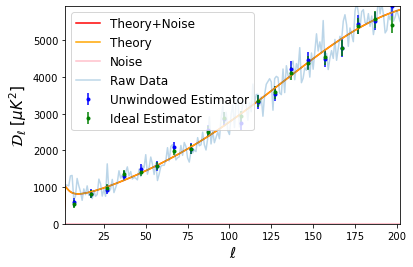

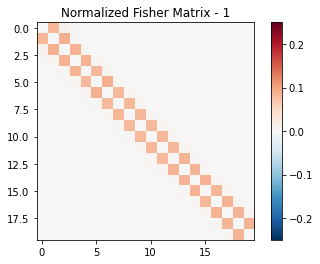

In [24]:
l_av = np.asarray([min_l+dl/2+dl*bin1 for bin1 in range(Nl)])
pref_av = l_av*(l_av+1.)/(2.*np.pi)*1e12
pref = l*(l+1)/(2.*np.pi)*1e12

fish_err = np.sqrt(np.diag(pspec.inv_fish))
fish_err_ideal = np.sqrt(np.diag(pspec.inv_fish_ideal))*np.sqrt(np.mean(mask**4.)/np.mean(mask**2)**2)

# Compute the HEALPix unbinned pseudo-Cl power spectrum, for comparison
Cl_raw_healpy = healpy.alm2cl(base.safe_divide(base.to_lm(raw_data),base.beam_lm))

# Plot spectra
plt.errorbar(l_av,pref_av*Cl_opt,yerr=pref_av*fish_err,marker='.',ls='',label='Unwindowed Estimator',c='b')
plt.errorbar(l_av,pref_av*Cl_ideal,yerr=pref_av*fish_err_ideal,marker='.',ls='',label='Ideal Estimator',c='g')
plt.plot(l,pref*(Cl_th+Nl_th/(1e-12+beam**2)),label='Theory+Noise',c='r')
plt.plot(l,pref*(Cl_th),label='Theory',c='orange')
plt.plot(l,pref*(Nl_th/(1e-12+beam**2)),label='Noise',c='pink')
plt.plot(l,pref*Cl_raw_healpy,label='Raw Data',alpha=0.3)
plt.xlim([min_l,min_l+dl*Nl])
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$\mathcal{D}_\ell\,\,[\mu K^2]$',fontsize=15)
plt.legend(fontsize=12)
plt.ylim([0,max(pref_av*Cl_opt)])

# Plot correlation matrix
plt.figure()
corr_fish = fish/np.sqrt(np.outer(np.diag(fish),np.diag(fish)))
v = 0.25
plt.imshow(corr_fish-np.eye(len(corr_fish)),cmap=cm.RdBu_r,vmax=v,vmin=-v)
plt.title("Normalized Fisher Matrix - 1")
plt.colorbar();

### Iterate over multiple data-sets
We can test whether the estimator is (close-to) minimum variance by iterating over GRF datasets. This is fast, since we don't need to recompute the Fisher matrix!

In [25]:
N_sim = 50

In [26]:
Cl_unwindowed_all = []
Cl_ideal_all = []
Cl_raw_all = []

for ii in range(N_sim):
    if ii%10==0: 
        print("Analyzing simulation %d of %d"%(ii+1,N_sim))
    
    # Generate data (pure GRFs here)
    raw_sim = base.generate_data(ii,add_B=False)
    sim = mask*raw_sim
    
    # Compute binned and unbinned power spectra
    Cl_unwindowed_all.append(pspec.Cl_unwindowed(sim))
    Cl_ideal_all.append(pspec.Cl_ideal(sim))
    raw_sim_lm = base.safe_divide(healpy.map2alm(raw_sim),pspec.base.beam_lm)
    Cl_raw_all.append(healpy.alm2cl(raw_sim_lm))

Analyzing simulation 1 of 50
Analyzing simulation 11 of 50
Analyzing simulation 21 of 50
Analyzing simulation 31 of 50
Analyzing simulation 41 of 50


Below, we plot the results. Importantly, the variance of the unwindowed estimator matches its Fisher matrix - i.e. it is roughly optimal! (Note that perfect optimality is only guaranteed if we use optimal weights).

However, it looks like the idealized estimator has a *lower* variance? This is due to the off-diagonal correlations imposed by the window function, as seen in the correlation matrices.

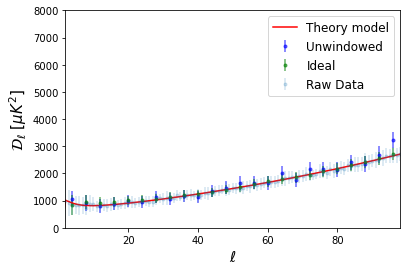

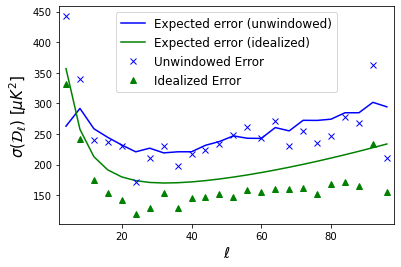

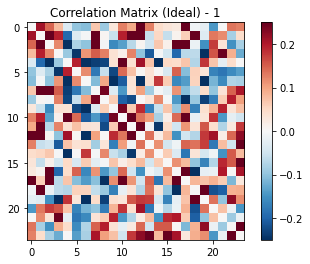

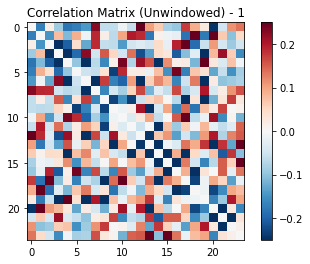

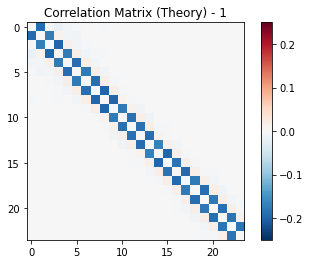

In [19]:
fish_err = np.sqrt(np.diag(pspec.inv_fish))
fish_err_ideal = np.sqrt(np.diag(pspec.inv_fish_ideal))*np.sqrt(np.mean(mask**4)/np.mean(mask**2)**2)
plt.errorbar(l_av,pref_av*np.asarray(Cl_unwindowed_all).mean(axis=0),yerr=pref_av*fish_err,marker='.',ls='',label='Unwindowed',c='b',alpha=0.6)
plt.errorbar(l_av,pref_av*np.asarray(Cl_ideal_all).mean(axis=0),yerr=pref_av*fish_err_ideal,marker='.',ls='',label='Ideal',c='g',alpha=0.6)
plt.plot(l,pref*(Cl_th+Nl_th/beam**2),label='Theory model',c='r')
plt.errorbar(l,pref*np.asarray(Cl_raw_all).mean(axis=0),yerr=pref*np.asarray(Cl_raw_all).std(axis=0),
             ls='',marker='.',label='Raw Data',alpha=0.2)
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$\mathcal{D}_\ell\,\,[\mu K^2]$',fontsize=15)
plt.legend(fontsize=12)
plt.ylim([0,8000])
plt.xlim([np.min(l_bins),np.max(l_bins)])

plt.figure()
plt.plot(l_av,pref_av*fish_err,label='Expected error (unwindowed)',c='b')
plt.plot(l_av,pref_av*fish_err_ideal,label='Expected error (idealized)',c='g')
plt.plot(l_av,pref_av*np.asarray(Cl_unwindowed_all).std(axis=0),label='Unwindowed Error',c='b',marker='x',ls='')
plt.plot(l_av,pref_av*np.asarray(Cl_ideal_all).std(axis=0),label='Idealized Error',c='g',marker='^',ls='')
plt.xlabel(r'$\ell$',fontsize=15)
plt.legend(fontsize=12)
plt.ylabel(r'$\sigma(\mathcal{D}_\ell)\,\,[\mu K^2]$',fontsize=15);
plt.xlim([np.min(l_bins),np.max(l_bins)])

# Plot correlation matrices
cov_ideal = np.cov(np.asarray(Cl_ideal_all).T)
corr_ideal = cov_ideal/np.sqrt(np.outer(np.diag(cov_ideal),np.diag(cov_ideal)))
cov_unwindowed = np.cov(np.asarray(Cl_unwindowed_all).T)
corr_unwindowed = cov_unwindowed/np.sqrt(np.outer(np.diag(cov_unwindowed),np.diag(cov_unwindowed)))
cov_theory = np.linalg.inv(pspec.fish)
corr_theory = cov_theory/np.sqrt(np.outer(np.diag(cov_theory),np.diag(cov_theory)))

plt.figure()
v = 0.25
plt.imshow(corr_ideal-np.eye(len(corr_ideal)),cmap=cm.RdBu_r,vmax=v,vmin=-v)
plt.title("Correlation Matrix (Ideal) - 1")
plt.colorbar();

plt.figure()
plt.imshow(corr_unwindowed-np.eye(len(corr_unwindowed)),cmap=cm.RdBu_r,vmax=v,vmin=-v)
plt.title("Correlation Matrix (Unwindowed) - 1")
plt.colorbar();

plt.figure()
plt.imshow(corr_theory-np.eye(len(corr_theory)),cmap=cm.RdBu_r,vmax=v,vmin=-v)
plt.title("Correlation Matrix (Theory) - 1")
plt.colorbar();

# 3. Bispectrum estimation

We now move to estimating the bispectrum, both via idealized and window-free estimators. As before, we will need to compute a Fisher matrix, depending on the survey geometry. To avoid the dimensionality (and run-time) getting out of hand, we will use a broad binning for this exercise, noting that bispectra are much more computationally expensive than power spectra! In practice, one would usually run the Fisher matrix on a cluster rather than on a laptop.

In [29]:
# Binning parameters
l_bins = np.arange(2,60,10)
l_bins_squeeze = np.arange(2,70,10)

In [30]:
# Initialize bispectrum class
bspec = pb.BSpec(base, mask, applySinv, l_bins,l_bins_squeeze=l_bins_squeeze)

Binning: 5 bins in [2, 52]
Squeezed binning: 6 bins in [2, 62]


In [31]:
# Define centers of l1, l2, l3 bins
l1s,l2s,l3s = np.asarray(bspec.get_ells())

# Print out a few bin centers:
for i in range(5):
    print("Bin %d: l1 = %d, l2 = %d, l3 = %d"%(i,l1s[i],l2s[i],l3s[i]))

Bin 0: l1 = 7, l2 = 7, l3 = 7
Bin 1: l1 = 7, l2 = 17, l3 = 17
Bin 2: l1 = 7, l2 = 27, l3 = 27
Bin 3: l1 = 7, l2 = 37, l3 = 37
Bin 4: l1 = 7, l2 = 47, l3 = 47


### Ideal Estimator

Let's start by computing the ideal bispectrum. This is a little more expensive than before, requiring $\mathcal{O}(N_{\rm bin})$ harmonic transforms. This function computes the normalization internally via a sum over Wigner matrices involving $\ell_1,\ell_2,\ell_3$.

In [32]:
b_ideal = bspec.Bl_ideal(data)

Computing ideal Fisher matrix
Using 33 bispectrum bins


### Window-free estimator
The window-free estimator can be computed similarly to the bispectrum, and involves a Fisher matrix that can be computed internally or externally.

We also require a set of Monte Carlo simulations to form the linear term in the bispectrum estimator (i.e. that involving $a\langle{aa\rangle}$). These can be generated by the code (as GRFs, optionally with an added factorizable bispectrum), or read-in from some external source. These should have the same covariance as the data (but do not need to have accurate higher-order statistics). 

In [33]:
# Generate MC simulations for estimator numerator
bspec.generate_sims(N_it,b_input=b_input_fac,add_B=True,remove_mean=True)

# # Alternatively, read-in MC simulations created externally
# alpha_sims = []
# for ii in range(N_it):
#     alpha = base.generate_data(seed=10000+ii,add_B=include_synthetic_b, b_input=b_input_fac)
#     alpha_sims.append(alpha)
# bspec.load_sims(alpha_sims, verb=True)

Using 10 Monte Carlo simulations


In [34]:
# Compute the Fisher matrix, via multiprocessing
fish = bspec.compute_fisher(N_it, N_cpus=4)

# Compute the unwindowed estimator, optionally removing the linear term
b_unwindowed = bspec.Bl_unwindowed(data, verb=True, include_linear_term=True)

Computing Fisher contribution from 10 pairs of Monte Carlo simulations on 4 threads


 20%|██        | 2/10 [02:52<11:30, 86.32s/it] 


KeyboardInterrupt: 

Process ForkPoolWorker-18:
Traceback (most recent call last):
Process ForkPoolWorker-19:
  File "/home/ophilcox/.conda/envs/sbi/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ophilcox/.conda/envs/sbi/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/ophilcox/.conda/envs/sbi/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/ophilcox/.conda/envs/sbi/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ophilcox/cmb-4pt/polybin/bspec.py", line 356, in _iterable
    return self.compute_fisher_contribution(seed)
Process ForkPoolWorker-17:
  File "/home/ophilcox/.conda/envs/sbi/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/ophilco

As before, we can compute the Fisher matrix externally (e.g., on a cluster) and read it in.

In [35]:
# Iterate by hand
fish = 0.
for i in range(N_it):
    if i%5==0: print("On iteration %d of %d"%(i+1,N_it))
    fish += bspec.compute_fisher_contribution(i, verb=(i==0))/N_it

# Compute unwindowed estimator, passing the Fisher matrix
b_unwindowed = bspec.Bl_unwindowed(data, verb=True, fish=fish, include_linear_term=True)

On iteration 1 of 10
Generating pair of GRFs
Creating H_b maps
Computing (H_b H_b')_{lm}
Computing Q(b) maps
Computing Fisher matrix
Computing b_3 piece
Computing b_1 piece from simulation 5
Computing b_1 piece from simulation 10


Now let's plot the results!

Bispectra are harder to plot than power spectra, due to their higher dimensionality. Here, we'll just stack all the data into one dimension. This starts with $b_1=b_2=b_3=1$, then updates each bin in turn, starting with $b_3$ and selecting only bins satisfying the triangle condition.

Below, we'll compare the results from the two estimators as well as the theory model. We'll also consider the Fisher matrix. Notably, we can see non-trivial off-diagonal correlations imparted by the survey geometry.

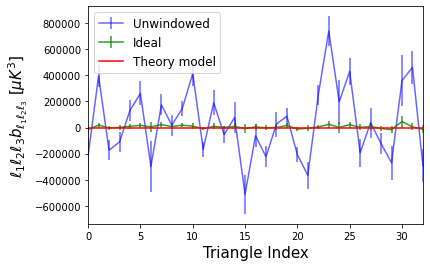

In [36]:
fish_err = np.sqrt(np.diag(np.linalg.inv(bspec.fish)))
weights = l1s*l2s*l3s*1e18
bl_model = b_input_fac(l1s)*b_input_fac(l2s)*b_input_fac(l3s)

fish_err_ideal = np.sqrt(np.diag(np.linalg.inv(bspec.fish_ideal))*np.mean(mask**6.)/np.mean(mask**3)**2)
plt.errorbar(np.arange(bspec.N_b),weights*b_unwindowed,yerr=weights*fish_err,label='Unwindowed',c='b',alpha=0.6)
plt.errorbar(np.arange(bspec.N_b),weights*b_ideal,yerr=weights*fish_err_ideal,label='Ideal',c='g',alpha=0.8)
if include_synthetic_b:
    plt.errorbar(np.arange(bspec.N_b),weights*bl_model,label='Theory model',c='r')
else:
    plt.errorbar(np.arange(bspec.N_b),0.*weights*bl_model,label='Theory model',c='r')
plt.legend(fontsize=12)
plt.xlim([0,bspec.N_b-1])
plt.xlabel("Triangle Index",fontsize=15)
plt.ylabel(r"$\ell_1\ell_2\ell_3 b_{\ell_1\ell_2\ell_3}\,\,[\mu K^3]$",fontsize=15);

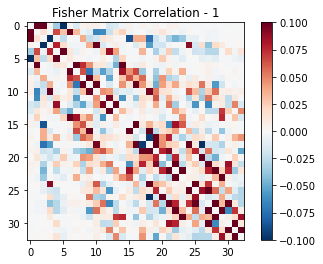

In [37]:
corr_fish_b = bspec.fish/np.sqrt(np.outer(np.diag(bspec.fish),np.diag(bspec.fish)))
v = 0.1
plt.imshow(corr_fish_b-np.eye(len(corr_fish_b)),cmap=cm.RdBu_r,vmax=v,vmin=-v)
plt.title("Fisher Matrix Correlation - 1")
plt.colorbar();

### Iterate over multiple datasets

To test the estimators, we can compute the variance from a suite of mock datasets, as for the power spectrum. This is comparatively cheap, since we have already loaded the Monte Carlo simulations (for the linear term) and the Fisher matrix.

In [38]:
b_unwindowed_all = []
b_ideal_all = []

for jj in range(10):#N_sim):
    
    if jj%10==0: 
        print("Analyzing simulation %d of %d"%(jj+1,N_sim))

    # Generate unmasked data
    data = mask*base.generate_data(jj,add_B=include_synthetic_b, b_input=b_input_fac)

    b_ideal_all.append(bspec.Bl_ideal(data))
    b_unwindowed_all.append(bspec.Bl_unwindowed(data,verb=False))

Analyzing simulation 1 of 50


Below, we plot the results and consider the errors. Once again, the variance is very close to the Fisher matrix prediction, i.e. we are close to optimal!

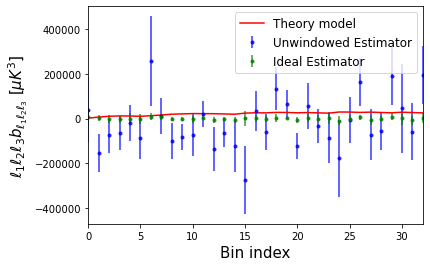

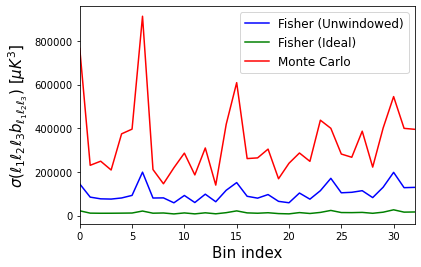

In [39]:
fish_err = np.sqrt(np.diag(bspec.inv_fish))
fish_err_ideal = np.sqrt(np.diag(bspec.inv_fish_ideal))

plt.errorbar(np.arange(bspec.N_b),weights*np.asarray(b_unwindowed_all).mean(axis=0),yerr=weights*fish_err,marker='.',ls='',label='Unwindowed Estimator',c='b',alpha=0.8)
plt.plot(np.arange(bspec.N_b),weights*bl_model,label='Theory model',c='r')
plt.errorbar(np.arange(bspec.N_b),weights*np.asarray(b_ideal_all).mean(axis=0),yerr=weights*np.asarray(b_ideal_all).std(axis=0),
             ls='',marker='.',label='Ideal Estimator',alpha=0.8,c='g')
plt.xlim([0,bspec.N_b-1])
plt.xlabel(r'Bin index',fontsize=15)
plt.ylabel(r'$\ell_1\ell_2\ell_3b_{\ell_1\ell_2\ell_3}\,\,[\mu K^3]$',fontsize=15)
plt.legend(fontsize=12)

plt.figure()
plt.plot(np.arange(bspec.N_b),weights*fish_err,label='Fisher (Unwindowed)',c='b')
plt.plot(np.arange(bspec.N_b),weights*fish_err_ideal,label=r'Fisher (Ideal)',c='g')
plt.plot(np.arange(bspec.N_b),weights*np.asarray(b_unwindowed_all).std(axis=0),label='Monte Carlo',c='r')
plt.xlabel(r'Bin index',fontsize=15)
plt.xlim([0,bspec.N_b-1])
plt.legend(fontsize=12)
plt.ylabel(r'$\sigma(\ell_1\ell_2\ell_3b_{\ell_1\ell_2\ell_3})\,\,[\mu K^3]$',fontsize=15);

# 4. Trispectrum Estimation

Finally, we consider the trispectrum. This is computed in a similar way to before, but there are a few key differences: one is that we can estimate both a *parity-even* and *parity-odd* trispectrum. (The parity-odd parts of an isotropic scalar field are trivially zero for the lower-point functions).

Since trispectrum estimation is considerably more expensive than power spectrum or bispectrum estimation, we'll use a broader binning here. In general, calculations would be performed on a cluster, but we'll pick a small problem below for testing on a single computer.

In [136]:
# Initialize trispectrum class and pick binning
# Here, we'll use a non-linear binning for demonstration [this gives roughly equal (S/N)^2 per bin]
l_bins = np.asarray(5+np.arange(0,15**0.4,1**0.4)**2.5,dtype='int')

# Let's also use slightly lower L_max (collapsed configurations), but the same for squeezed configurations
L_bins = l_bins[:-1]
l_bins_squeeze = l_bins.copy()

In [137]:
tspec = pb.TSpec(base, mask, applySinv, l_bins, l_bins, l_bins)

Binning: 2 bins in [5, 10]


In [138]:
# Define centers of l1, l2, l3, l4, L bins
l1s,l2s,l3s,l4s,Ls,parities = tspec.get_ells()

# Print out a few bin centers:
for i in range(10):
    print("Bin %d: l1 = %d, l2 = %d,l3 = %d, l4=%d, L=%d, parity = %s"%(i,l1s[i],l2s[i],l3s[i],l4s[i],Ls[i],parities[i]))

Bin 0: l1 = 5, l2 = 5,l3 = 5, l4=5, L=5, parity = even
Bin 1: l1 = 5, l2 = 5,l3 = 5, l4=5, L=8, parity = even
Bin 2: l1 = 5, l2 = 5,l3 = 5, l4=8, L=5, parity = both
Bin 3: l1 = 5, l2 = 5,l3 = 5, l4=8, L=8, parity = both
Bin 4: l1 = 5, l2 = 5,l3 = 8, l4=8, L=5, parity = both
Bin 5: l1 = 5, l2 = 5,l3 = 8, l4=8, L=8, parity = both
Bin 6: l1 = 5, l2 = 8,l3 = 5, l4=8, L=5, parity = even
Bin 7: l1 = 5, l2 = 8,l3 = 5, l4=8, L=8, parity = even
Bin 8: l1 = 5, l2 = 8,l3 = 8, l4=8, L=5, parity = both
Bin 9: l1 = 5, l2 = 8,l3 = 8, l4=8, L=8, parity = both


In [139]:
len(l1s)

12

### Ideal Estimator

As before, we start by computing the ideal trispectrum. This has similar computational cost to the bispectrum, but involves a few more spherical harmonic transforms, to account for the $L$ diagonal vector. The ideal estimator computes the normalization internally via a sum over a selection of Wigner $3j$ and $6j$ matrices: notably this is not diagonal, unlike for the power spectrum and bispectrum. Computation may take a while if $\ell_{\rm max}$ is large!

Note that we can now choose whether to compute "odd" or "even" spectra: if one wants to compute both spectra, it is more efficient to choose ```parity="both"``` than run even and odd separately! Note that the spectra are uncorrelated in the ideal limit.

In [140]:
# t_ideal_even, t_ideal_odd = tspec.Tl_ideal(data,parity='both',verb=True)

Let's look at the structure of the Fisher matrices:

In [141]:
# for fish in tspec.fish_ideal_even, tspec.fish_ideal_odd:
#     corr = fish/np.sqrt(np.outer(np.diag(fish),np.diag(fish)))
#     v = 0.25
#     plt.imshow(corr,vmax=v,vmin=-v,cmap=cm.RdBu_r)
#     plt.xlabel(r'Bin Index 1',fontsize=15)
#     plt.ylabel(r'Bin Index 2',fontsize=15)

In [142]:
fish_odd = tspec.compute_fisher(1,parity='odd',N_cpus=1,verb=True)

Using 6 odd-parity trispectrum bins
Computing Fisher contribution 1 of 1

Generating data

Creating H maps for S-inverse-weighted fields
Computing A[u1,u2] maps for S-inverse-weighted fields
Computing raw Q maps for S-inverse-weighted fields
Assembling Q filters for S-inverse-weighted fields

Creating H maps for U-inverse-weighted fields
Computing A[u1,u2] maps for U-inverse-weighted fields
Computing raw Q maps for U-inverse-weighted fields
Assembling Q filters for U-inverse-weighted fields

Computing Fisher matrix contribution
On bin 1 of 6
On bin 6 of 6


In [143]:
tspec.generate_sims(10)

Using 10 pairs of Monte Carlo simulations


## note that we can multiprocess trispectrum ideal fisher?

In [144]:
t_odd = tspec.Tl_unwindowed(data,parity='odd',verb=True)

Computing t0 term
Computing H^+- maps
Computing A maps
Computing A maps for cross-spectra
Assembling parity-odd trispectrum numerator


In [146]:
t_odd05 = t_odd.copy()
fish_odd05 = fish_odd.copy()

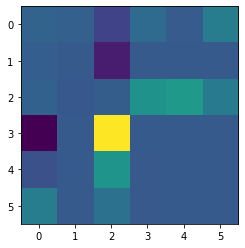

In [147]:
plt.imshow(fish_odd1/fish_odd05)

In [148]:
(fish_odd1/fish_odd05)

array([[16., 16., 16., 16., 16., 16.],
       [16., 16., 16., 16., 16., 16.],
       [16., 16., 16., 16., 16., 16.],
       [16., 16., 16., 16., 16., 16.],
       [16., 16., 16., 16., 16., 16.],
       [16., 16., 16., 16., 16., 16.]])

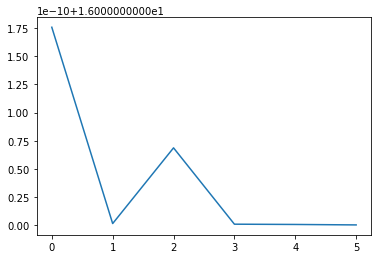

In [149]:
#plt.plot(t_odd1/t_odd05)
plt.plot(np.diag(fish_odd1)/np.diag(fish_odd05))

In [54]:
fishs = []
for i in range(5):
    print("On realization %d"%(i+1))
    fish_i = tspec.compute_fisher_contribution(i,parity='both',verb=False)
    fishs.append(fish_i)

On realization 1
Using 51 even-parity trispectrum bins
Using 35 odd-parity trispectrum bins
On realization 2
On realization 3
On realization 4
On realization 5


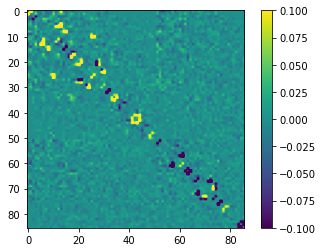

In [60]:
#ff = np.asarray(fishs).mean(axis=0)
#sf = np.asarray(fishs).std(axis=0)
corr_fish = ff/np.sqrt(np.outer(np.diag(ff),np.diag(ff)))
v=0.1
plt.imshow(corr_fish-np.eye(len(corr_fish)),vmax=v,vmin=-v);
plt.colorbar();

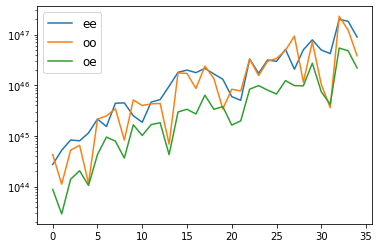

In [56]:
self = tspec
eo_bin = []
for bin1 in range(self.Nl):
    for bin2 in range(bin1,self.Nl):
        for bin3 in range(bin1,self.Nl):
            for bin4 in range(bin3,self.Nl):
                # always include all bins here for counting!
                if bin1==bin3 and bin4<bin2: continue
                for binL in range(self.Nl):
                    # skip bins outside the triangle conditions
                    if not self._check_bin(bin1,bin2,binL,even=False): continue
                    if not self._check_bin(bin3,bin4,binL,even=False): continue
                    if bin1==bin3 and bin4==bin2:
                        eo_bin.append(False)
                    else:
                        eo_bin.append(True)

fee = sf[:tspec.N_t_even,:tspec.N_t_even][eo_bin][:,eo_bin]
feo = sf[:tspec.N_t_even,tspec.N_t_even:][eo_bin]
foe = sf[tspec.N_t_even:,:tspec.N_t_even][:,eo_bin]
foo = sf[tspec.N_t_even:,tspec.N_t_even:]

plt.plot(np.diag(fee),label='ee')
plt.plot(np.diag(foo),label='oo')
plt.plot(np.diag(foe),label='oe')
plt.legend(fontsize=12)
plt.yscale('log')

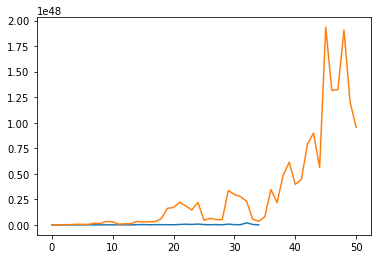

In [57]:
plt.plot(np.diag(sf[tspec.N_t_even:,:tspec.N_t_even]))
plt.plot(np.diag(ff[:tspec.N_t_even]))

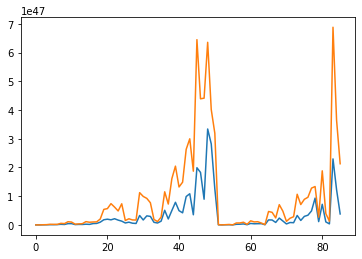

In [58]:
plt.plot(np.diag(sf))
plt.plot(np.diag(ff)/3.)

In [10]:
fish_both = tspec.compute_fisher(1,parity='both',N_cpus=1,verb=True)

Computing Fisher contribution 1 of 1

Generating data

Creating H maps for S-inverse-weighted fields
Computing A[u1,u2] maps for S-inverse-weighted fields
Computing raw Q maps for S-inverse-weighted fields
Assembling Q filters for S-inverse-weighted fields

Creating H maps for U-inverse-weighted fields
Computing A[u1,u2] maps for U-inverse-weighted fields
Computing raw Q maps for U-inverse-weighted fields
Assembling Q filters for U-inverse-weighted fields

Computing Fisher matrix contribution
On bin 1 of 154
On bin 6 of 154
On bin 11 of 154
On bin 16 of 154
On bin 21 of 154
On bin 26 of 154
On bin 31 of 154
On bin 36 of 154
On bin 41 of 154
On bin 46 of 154
On bin 51 of 154
On bin 56 of 154
On bin 61 of 154
On bin 66 of 154
On bin 71 of 154
On bin 76 of 154
On bin 81 of 154
On bin 86 of 154
On bin 91 of 154
On bin 96 of 154
On bin 101 of 154
On bin 106 of 154
On bin 111 of 154
On bin 116 of 154
On bin 121 of 154
On bin 126 of 154
On bin 131 of 154
On bin 136 of 154
On bin 141 of 154
On

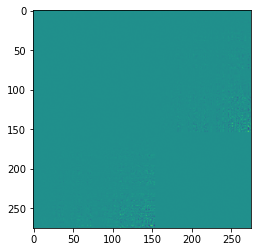

In [20]:
plt.imshow(fish_both-fish_both.T)

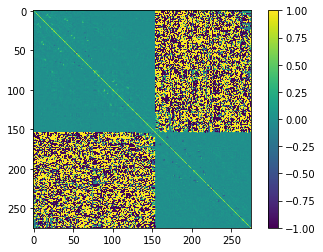

In [24]:
ff = fish_both
corr_fish = ff/np.sqrt(np.outer(np.diag(ff),np.diag(ff)))
plt.imshow(corr_fish,vmax=1,vmin=-1);
plt.colorbar();

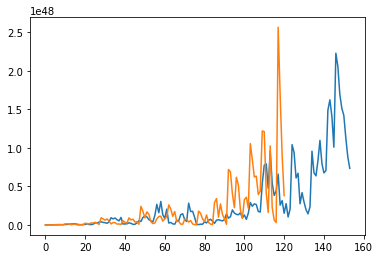

In [15]:
plt.plot(np.diag(fish_both)[:tspec.N_t_even])
plt.plot(np.diag(fish_both)[tspec.N_t_even:])

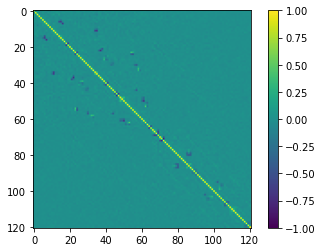

In [7]:
ff = fish_odd
corr_fish = ff/np.sqrt(np.outer(np.diag(ff),np.diag(ff)))
plt.imshow(corr_fish,vmax=1,vmin=-1);
plt.colorbar();

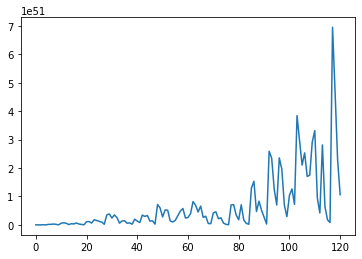

In [8]:
plt.plot(np.diag(fish_odd))

<ErrorbarContainer object of 3 artists>

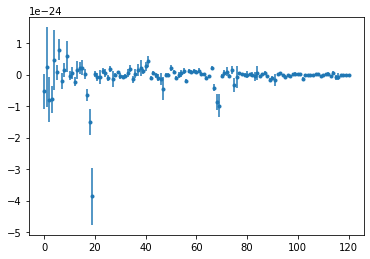

In [9]:
plt.errorbar(np.arange(tspec.N_t_odd),t_odd,yerr=np.sqrt(np.diag(tspec.inv_fish_odd)),ls='',marker='.')

### no mask here!

### a) window is weird??

### b) off-diagonal is weird - should asymptote to zero?

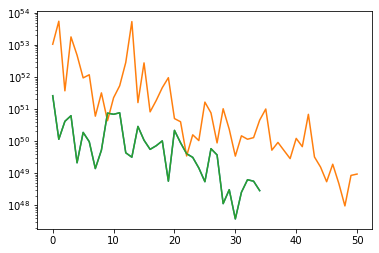

In [20]:
plt.plot(np.abs(np.diag(fish_both)[tspec.N_t_even:]))
plt.plot(np.diag(fish_even))
plt.plot(-np.diag(fish_odd))
plt.yscale('log')

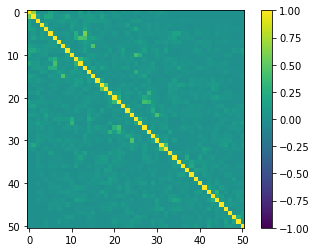

In [40]:
ff = np.abs(fish_even)
corr_fish = ff/np.sqrt(np.outer(np.diag(ff),np.diag(ff)))
plt.imshow(corr_fish,vmax=1,vmin=-1);
plt.colorbar();

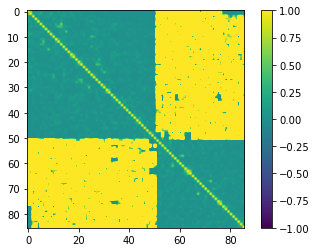

In [43]:
ff = np.abs(fish_both)
corr_fish = ff/np.sqrt(np.outer(np.diag(ff),np.diag(ff)))
plt.imshow(corr_fish,vmax=1,vmin=-1);
plt.colorbar();

In [47]:
tspec.generate_sims(10,Cl_th+Nl_th)

Using 10 Monte Carlo simulations


In [48]:
t_unwindowed_even = tspec.Tl_numerator(data,parity='both',verb=True)

Computing t0 term
Computing t0 term
Computing H^+- maps
Computing A maps
Computing A maps for cross-spectra
Assembling parity-even trispectrum numerator
Assembling parity-odd trispectrum numerator


### cross-terms don't seem to work yet??
### check there's the same symmetry there!

### could check just with a constant window that there's no effects?

## can we use transpose symmetry to drop half the Fisher matrix bins? force index2>index1?

## switch to just computing Im part of trispectrum?
## also helps in Fisher?

In [3]:
t_even, t_odd = tspec.Tl_ideal(data,parity='both',verb=True)

Computing ideal Fisher matrix
Using 51 even-parity trispectrum bins
Using 35 odd-parity trispectrum bins
Computing bin 5 of 51
Computing bin 10 of 51
Computing bin 15 of 51
Computing bin 20 of 51
Computing bin 25 of 51
Computing bin 30 of 51
Computing bin 35 of 51
Computing bin 40 of 51
Computing bin 45 of 51
Computing bin 50 of 51
Computing numerator
Computing H^+- maps
Computing A maps
Assembling parity-even trispectrum numerator
Assembling parity-odd trispectrum numerator


In [4]:
t_even2 = tspec.Tl_ideal(data,parity='even',verb=True)

Using precomputed Fisher matrix
Computing numerator
Computing H^+- maps
Computing A maps
Assembling parity-even trispectrum numerator
